# 第6章   深度学习用于文本和序列

## 6.1   处理文本数据

### 6.1.1   单词和字符的one-hot编码

##### 6-3   用Keras实现单词级的one-hot编码

In [1]:
from keras.preprocessing.text import Tokenizer

In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

In [3]:
tokenizer = Tokenizer(num_words = 100)   # 创建一个分词器，设置为只考虑前1000个最常见的单词
tokenizer.fit_on_texts(samples)   # 构建单词索引

In [4]:
sequences = tokenizer.texts_to_sequences(samples)   # 将字符串转换为整数索引组成的列表
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [5]:
one_hot_results = tokenizer.texts_to_matrix(samples, mode = 'binary')   # 也可以直接得到one-hot二进制表示
one_hot_results   # 0号为保留索引，不会被分配给任何单词

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [6]:
word_index = tokenizer.word_index
word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

##### 6-4   使用散列技巧的单词级的one-hot编码

In [7]:
dimensionality = 1000
max_length = 10

In [8]:
import numpy as np

In [9]:
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

In [10]:
list(enumerate(samples))

[(0, 'The cat sat on the mat.'), (1, 'The dog ate my homework.')]

### 6.1.2   使用词嵌入

#### 1.使用`Embedding`层学习词嵌入

##### 6-5   将一个`Embedding`层实例化

In [11]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)   # 两个参数：标记的个数（最大单词索引+1）和嵌入的维度

##### 6-6   加载IMDB数据，准备用于`Embedding`层

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from keras.datasets import imdb
from keras import preprocessing   # 与书上有出入

In [14]:
max_features = 10000   # 作为特征的单词个数
maxlen = 20   # 在20个单词后截断文本
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)   # 将数据加载为整数列表
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)   
# 将整数列表转换成形状为(samples,maxlen)的二维整数张量

##### 6-7   在IMDB数据上使用`Embedding`层和分类器

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [16]:
model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen))   # 指定Embedding层的最大输出长度
# Embedding层激活形状：(samples,maxlen,8)
model.add(Flatten())   # 将三维的嵌入张量展平成形状为(samples,maxlen*8)的二维张量
model.add(Dense(1, activation = 'sigmoid'))   # 添加分类器
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6871 - acc: 0.5577 - val_loss: 0.6280 - val_acc: 0.6990
Epoch 2/10
625/625 [==============================] - 1s 999us/step - loss: 0.5792 - acc: 0.7367 - val_loss: 0.5302 - val_acc: 0.7354
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4755 - acc: 0.7813 - val_loss: 0.5017 - val_acc: 0.7480
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4232 - acc: 0.8097 - val_loss: 0.4955 - val_acc: 0.7560
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3922 - acc: 0.8253 - val_loss: 0.4942 - val_acc: 0.7564
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3699 - acc: 0.8363 - val_loss: 0.4972 - val_acc: 0.7580
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3452 - acc: 0.8553 - val_loss: 0.5018 - val_acc: 0.7554
Epoch 8/10
625/625 [==============================] - 1s 986us/step - loss

#### 2.使用预训练的词嵌入

>**step1:** 下载IMDB数据的原始文本

##### 6-8   处理IMDB原始数据的标签

In [18]:
import os

In [19]:
imdb_dir = '/Users/duoduo/Desktop/Data/Machine Learning/Deep Learning with Python/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [20]:
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

>**step2:** 对数据进行分词

##### 6-9   对IMDB原始数据的文本进行分词

In [21]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [22]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [23]:
word_index = tokenizer.word_index
len(word_index)

88582

In [24]:
data = preprocessing.sequence.pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [25]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [26]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

>**step3:** 下载GloVe词嵌入

>**step4:** 对嵌入进行预处理

##### 6-10   解析GloVe词嵌入文件

In [27]:
glove_dir = '/Users/duoduo/Desktop/Data/Machine Learning/Deep Learning with Python/glove.6B'

In [28]:
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()
len(embedding_index)

400000

##### 6-11   准备GloVe词嵌入矩阵

In [29]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
# 嵌入索引（embedding_index）中找不到的词，其嵌入向量全为0

>**step5:** 定义模型

##### 6-12   模型定义

In [30]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


>**step6:** 在模型中加载GloVe嵌入

##### 6-13   将预训练的词嵌入加载到`Embedding`层中

In [31]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False   # 冻结Embedding层，使其不被更新或破坏

>**step7:** 训练模型与评估模型

##### 6-14   训练与评估

In [32]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))
model.save_weights('/Users/duoduo/Desktop/Data/Machine Learning/Deep Learning with Python/pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 119ms/step - loss: 1.8699 - acc: 0.5062 - val_loss: 0.6957 - val_acc: 0.5180
Epoch 2/10
7/7 [==============================] - 0s 71ms/step - loss: 0.5546 - acc: 0.7073 - val_loss: 1.0961 - val_acc: 0.5051
Epoch 3/10
7/7 [==============================] - 0s 60ms/step - loss: 0.6486 - acc: 0.7072 - val_loss: 0.7514 - val_acc: 0.5146
Epoch 4/10
7/7 [==============================] - 0s 62ms/step - loss: 0.5008 - acc: 0.7282 - val_loss: 0.6888 - val_acc: 0.5528
Epoch 5/10
7/7 [==============================] - 0s 58ms/step - loss: 0.2554 - acc: 0.9698 - val_loss: 1.0685 - val_acc: 0.5054
Epoch 6/10
7/7 [==============================] - 0s 57ms/step - loss: 0.4544 - acc: 0.7251 - val_loss: 0.8232 - val_acc: 0.5359
Epoch 7/10
7/7 [==============================] - 0s 72ms/step - loss: 0.2392 - acc: 0.8887 - val_loss: 0.7760 - val_acc: 0.5424
Epoch 8/10
7/7 [==============================] - 0s 70ms/step - loss: 0.0767 - acc: 1.0000 - va

##### 6-15   绘制结果

In [33]:
import matplotlib.pyplot as plt

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

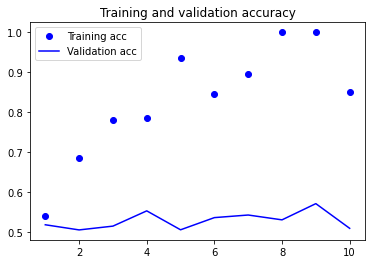

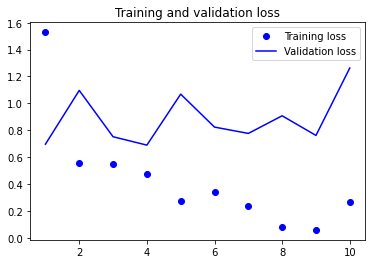

In [35]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### 6-17   对测试集数据进行分词

In [36]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

In [37]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [38]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = preprocessing.sequence.pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

##### 6-18   在测试集上评估模型

In [39]:
model.load_weights('/Users/duoduo/Desktop/Data/Machine Learning/Deep Learning with Python/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 1.2820 - acc: 0.5033


[1.2819582223892212, 0.503279983997345]

## 6.2   理解循环神经网络

### 6.2.1   Keras中的循环层

##### 6-22   准备IMDB数据 

In [40]:
max_features = 10000
maxlen = 500
batch_size = 32

In [41]:
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

25000 train sequences
25000 test sequences


In [42]:
input_train = preprocessing.sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = preprocessing.sequence.pad_sequences(input_test, maxlen = maxlen)
print('input_train shape: ', input_train.shape)
print('input_test shape: ', input_test.shape)

input_train shape:  (25000, 500)
input_test shape:  (25000, 500)


##### 6-23   用`Embedding`层和`SimpleRNN`层来训练模型

In [43]:
from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(input_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 18s 108ms/step - loss: 0.6765 - acc: 0.5626 - val_loss: 0.4930 - val_acc: 0.7704
Epoch 2/10
157/157 [==============================] - 17s 110ms/step - loss: 0.4184 - acc: 0.8183 - val_loss: 0.3613 - val_acc: 0.8472
Epoch 3/10
157/157 [==============================] - 17s 109ms/step - loss: 0.2936 - acc: 0.8806 - val_loss: 0.3379 - val_acc: 0.8630
Epoch 4/10
157/157 [==============================] - 16s 104ms/step - loss: 0.2347 - acc: 0.9102 - val_loss: 0.3766 - val_acc: 0.8358
Epoch 5/10
157/157 [==============================] - 16s 103ms/step - loss: 0.1727 - acc: 0.9354 - val_loss: 0.3777 - val_acc: 0.8566
Epoch 6/10
157/157 [==============================] - 17s 105ms/step - loss: 0.1381 - acc: 0.9510 - val_loss: 0.4498 - val_acc: 0.8286
Epoch 7/10
157/157 [==============================] - 16s 104ms/step - loss: 0.1089 - acc: 0.9630 - val_loss: 0.5738 - val_acc: 0.7542
Epoch 8/10
157/157 [==============================] - 1

##### 6-24   绘制结果

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

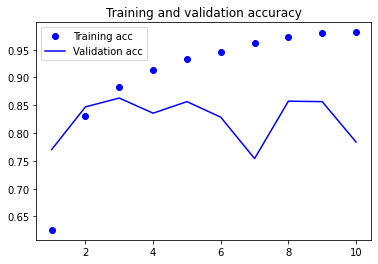

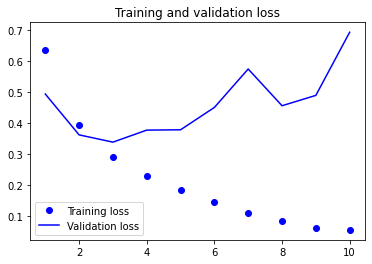

In [45]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.2.3   Keras中一个LSTM的具体例子

##### 6-27   使用Keras中的`LSTM`层

In [46]:
from keras.layers import LSTM

In [47]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(input_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 35s 213ms/step - loss: 0.6177 - acc: 0.6675 - val_loss: 0.4004 - val_acc: 0.8432
Epoch 2/10
157/157 [==============================] - 31s 195ms/step - loss: 0.3326 - acc: 0.8701 - val_loss: 0.3728 - val_acc: 0.8430
Epoch 3/10
157/157 [==============================] - 31s 198ms/step - loss: 0.2512 - acc: 0.9047 - val_loss: 0.3562 - val_acc: 0.8412
Epoch 4/10
157/157 [==============================] - 33s 212ms/step - loss: 0.2049 - acc: 0.9242 - val_loss: 0.3033 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 32s 204ms/step - loss: 0.1694 - acc: 0.9390 - val_loss: 0.2864 - val_acc: 0.8812
Epoch 6/10
157/157 [==============================] - 35s 224ms/step - loss: 0.1563 - acc: 0.9461 - val_loss: 0.3170 - val_acc: 0.8738
Epoch 7/10
157/157 [==============================] - 32s 206ms/step - loss: 0.1308 - acc: 0.9568 - val_loss: 0.3057 - val_acc: 0.8826
Epoch 8/10
157/157 [==============================] - 3

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

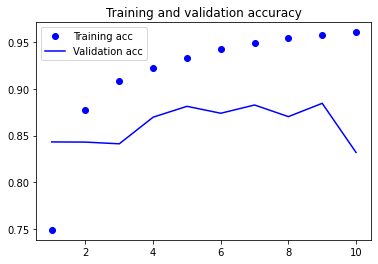

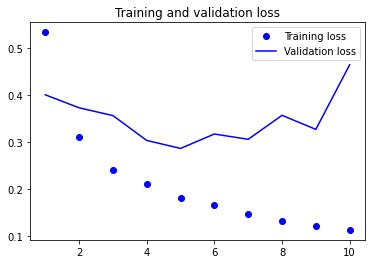

In [49]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 6.3   循环神经网络的高级用法

### 6.3.1   温度预测问题

##### 6-28   观察耶拿天气数据集的数据

In [50]:
fname = '/Users/duoduo/Desktop/Data/Machine Learning/Deep Learning with Python/jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()

In [51]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


##### 6-29   解析数据

In [52]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values 

##### 6-30   绘制温度时间序列

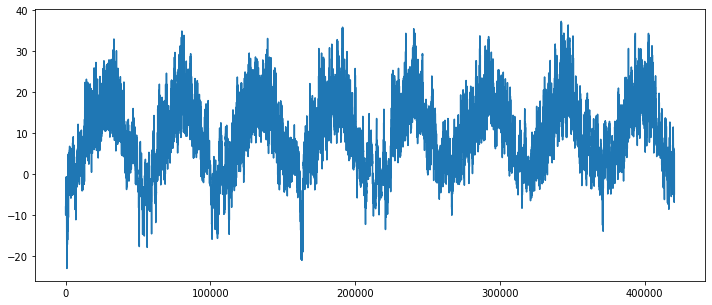

In [53]:
temp = float_data[:,1]
plt.figure(figsize = (12,5))
plt.plot(range(len(temp)), temp)

##### 6-31   绘制前10天的温度时间序列

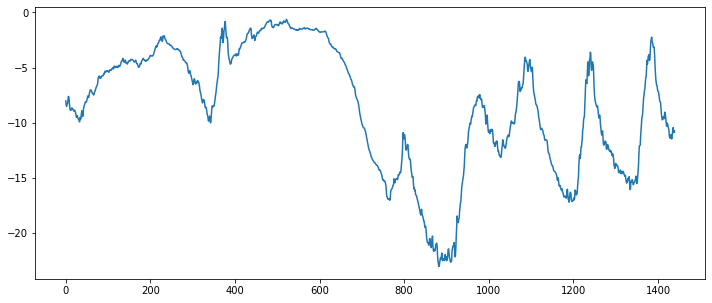

In [54]:
plt.figure(figsize = (12,5))
plt.plot(range(1440), temp[:1440])

##### 6-32   数据标准化

In [55]:
mean = float_data[:200000].mean(axis = 0)   # 使用前200000个时间步作为训练集
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

##### 6-33   生成时间序列样本及其目标的生成器

In [56]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

##### 6-34   准备训练生成器、验证生成器和测试生成器

In [57]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [58]:
train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000, 
                      shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000, 
                      step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None, 
                      step = step, batch_size = batch_size)

In [59]:
val_steps = (300000 - 200001 - lookback) // batch_size   # 查看整个验证集需要从val_gen中抽取几次
test_steps = (len(float_data) - 300001 - lookback) // batch_size   # 查看整个测试集需要从test_gen中抽取几次
print(val_steps)
print(test_steps)

769
929


### 6.3.3   一种基于常识的、非机器学习的基准方法

##### 6-35   计算符合常识的基准方法的MAE

In [67]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets)) 
        batch_maes.append(mae)
    return np.mean(batch_maes)   # 与书上有出入，需要设置返回值以便后续计算

In [68]:
std_mae = evaluate_naive_method()
std_mae

0.2897359729905486

In [69]:
celsius_mae = std_mae * std[1]
celsius_mae

2.564887434980494

### 6.3.4   一种基本的机器学习技法

##### 6-37   训练并评估一个密集连接模型

In [72]:
from keras.optimizers import RMSprop

In [73]:
model = Sequential()
model.add(Flatten(input_shape = (lookback//step, float_data.shape[-1])))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')

In [75]:
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, 
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 2.2270 - val_loss: 0.5318
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4925 - val_loss: 0.3166
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3021 - val_loss: 0.3069
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2692 - val_loss: 0.3040
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2573 - val_loss: 0.3297
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2460 - val_loss: 0.3220
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2375 - val_loss: 0.3111
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2350 - val_loss: 0.3492
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2288 - val_loss: 0.3244
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.222

##### 6-38   绘制结果

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

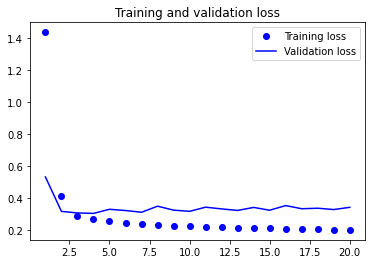

In [79]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.5   第一个循环网络基准

##### 6-39   训练并评估一个基于GRU的模型

In [80]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, 
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 60s 115ms/step - loss: 0.3205 - val_loss: 0.2703
Epoch 2/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2869 - val_loss: 0.2764
Epoch 3/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2805 - val_loss: 0.2761
Epoch 4/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2761 - val_loss: 0.2643
Epoch 5/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2726 - val_loss: 0.2620
Epoch 6/20
500/500 [==============================] - 56s 113ms/step - loss: 0.2663 - val_loss: 0.2643
Epoch 7/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2615 - val_loss: 0.2680
Epoch 8/20
500/500 [==============================] - 57s 113ms/step - loss: 0.2587 - val_loss: 0.2752
Epoch 9/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2552 - val_loss: 0.2852
Epoch 10/20
500/500 [==============================] - 57s 113ms/step - l

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

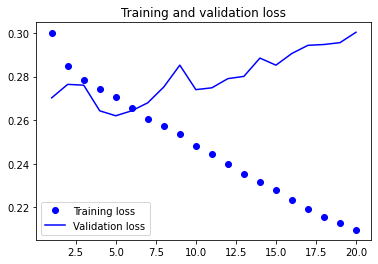

In [82]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.6   使用循环dropout来降低过拟合

##### 6-40   训练并评估一个使用dropout正则化的基于`GRU`的模型

In [ ]:
model = Sequential()
model.add(GRU(32, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, 
                              validation_steps = val_steps)

### 6.3.7   循环层堆叠

##### 6-41   训练并评估一个使用dropout正则化的堆叠`GRU`的模型

In [ ]:
model = Sequential()
model.add(GRU(32, dropout = 0.1, recurrent_dropout = 0.5, return_sequence = True, 
              input_shape = (None, float_data.shape[-1])))
model.add(GRU(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.5))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, 
                              validation_steps = val_steps)

### 6.3.8   使用双向RNN

##### 6-42   使用逆序序列训练并评估一个`LSTM`

In [84]:
max_features = 10000
maxlen = 500

In [85]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
x_train = [x[::-1] for x in x_train]   # 将序列反转
x_test = [x[::-1] for x in x_test]
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)

In [86]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 55s 336ms/step - loss: 0.5876 - acc: 0.6746 - val_loss: 0.3894 - val_acc: 0.8382
Epoch 2/10
157/157 [==============================] - 56s 357ms/step - loss: 0.3113 - acc: 0.8797 - val_loss: 0.3228 - val_acc: 0.8778
Epoch 3/10
157/157 [==============================] - 55s 349ms/step - loss: 0.2479 - acc: 0.9110 - val_loss: 0.3713 - val_acc: 0.8504
Epoch 4/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2148 - acc: 0.9229 - val_loss: 0.4195 - val_acc: 0.8278
Epoch 5/10
157/157 [==============================] - 54s 343ms/step - loss: 0.1710 - acc: 0.9430 - val_loss: 0.4323 - val_acc: 0.8384
Epoch 6/10
157/157 [==============================] - 58s 366ms/step - loss: 0.1632 - acc: 0.9396 - val_loss: 0.3337 - val_acc: 0.8816
Epoch 7/10
157/157 [==============================] - 58s 366ms/step - loss: 0.1356 - acc: 0.9546 - val_loss: 0.4043 - val_acc: 0.8778
Epoch 8/10
157/157 [==============================] - 5

In [87]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

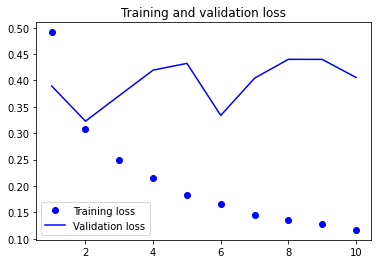

In [88]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### 6-43   训练并评估一个双向`LSTM`

In [89]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 51s 303ms/step - loss: 0.6561 - acc: 0.5969 - val_loss: 0.4547 - val_acc: 0.8008
Epoch 2/10
157/157 [==============================] - 49s 313ms/step - loss: 0.4176 - acc: 0.8328 - val_loss: 0.3265 - val_acc: 0.8706
Epoch 3/10
157/157 [==============================] - 49s 312ms/step - loss: 0.3010 - acc: 0.8872 - val_loss: 0.3143 - val_acc: 0.8818
Epoch 4/10
157/157 [==============================] - 46s 291ms/step - loss: 0.2589 - acc: 0.9052 - val_loss: 0.5661 - val_acc: 0.7666
Epoch 5/10
157/157 [==============================] - 46s 292ms/step - loss: 0.2207 - acc: 0.9209 - val_loss: 0.3245 - val_acc: 0.8850
Epoch 6/10
157/157 [==============================] - 46s 294ms/step - loss: 0.1956 - acc: 0.9343 - val_loss: 0.3615 - val_acc: 0.8398
Epoch 7/10
157/157 [==============================] - 45s 287ms/step - loss: 0.1665 - acc: 0.9408 - val_loss: 0.3685 - val_acc: 0.8684
Epoch 8/10
157/157 [==============================] - 5

In [90]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

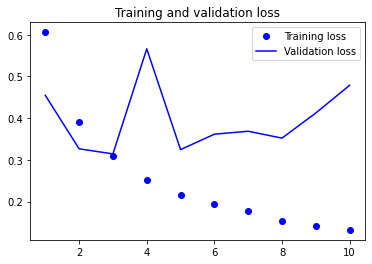

In [91]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### 6-44 训练一个双向`GRU`

In [ ]:
model = Sequential()
model.add(Bidirectional(GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, 
                    validation_steps = val_steps)

## 6.4   用卷积神经网络处理序列

### 6.4.3   实现一维卷积神经网络

##### 6-45   准备IMDB数据

In [92]:
max_features = 10000
max_len = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)

##### 6-46   在IMDB数据上训练并评估一个简单的一维卷积神经网络

In [93]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
model = Sequential()
model.add(Embedding(max_features, 128, input_length = max_len))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [94]:
model.compile(optimizer = RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 30s 187ms/step - loss: 0.8715 - acc: 0.5032 - val_loss: 0.6885 - val_acc: 0.5316
Epoch 2/10
157/157 [==============================] - 27s 171ms/step - loss: 0.6757 - acc: 0.6268 - val_loss: 0.6739 - val_acc: 0.6004
Epoch 3/10
157/157 [==============================] - 27s 175ms/step - loss: 0.6474 - acc: 0.7109 - val_loss: 0.6379 - val_acc: 0.7068
Epoch 4/10
157/157 [==============================] - 26s 166ms/step - loss: 0.5936 - acc: 0.7841 - val_loss: 0.5496 - val_acc: 0.7606
Epoch 5/10
157/157 [==============================] - 29s 183ms/step - loss: 0.4808 - acc: 0.8269 - val_loss: 0.4556 - val_acc: 0.8162
Epoch 6/10
157/157 [==============================] - 29s 186ms/step - loss: 0.3709 - acc: 0.8595 - val_loss: 0.4230 - val_acc: 0.8436
Epoch 7/10
157/157 [==============================] - 27s 173ms/step - loss: 0.3144 - acc: 0.8838 - val_loss: 0.4028 - val_acc: 0.8568
Epoch 8/10
157/157 [==============================] - 2

In [95]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss)+1)

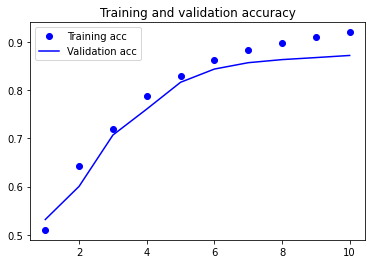

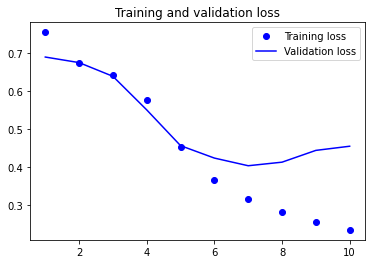

In [96]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.4.4   结合CNN和RNN来处理长序列

##### 6-47   在耶拿数据上训练并评估一个简单的一维卷积神经网络

In [97]:
model = Sequential()
model.add(Conv1D(32, 5, activation = 'relu', input_shape = (None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, 
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 22s 41ms/step - loss: 0.4496 - val_loss: 0.4467
Epoch 2/20
500/500 [==============================] - 20s 41ms/step - loss: 0.3629 - val_loss: 0.4397
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3339 - val_loss: 0.4314
Epoch 4/20
500/500 [==============================] - 22s 45ms/step - loss: 0.3156 - val_loss: 0.4331
Epoch 5/20
500/500 [==============================] - 23s 45ms/step - loss: 0.3028 - val_loss: 0.4483
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2932 - val_loss: 0.4448
Epoch 7/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2843 - val_loss: 0.4649
Epoch 8/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2766 - val_loss: 0.4360
Epoch 9/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2709 - val_loss: 0.4351
Epoch 10/20
500/500 [==============================] - 22s 45ms/step - loss: 0.267

In [98]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

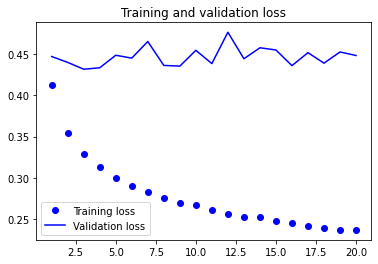

In [99]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### 6-48   为耶拿数据准备更高分辨率的数据生成器

In [100]:
step = 3
lookback = 720
delay = 144

In [101]:
train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000, 
                      shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000, 
                      step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None, 
                      step = step, batch_size = batch_size)

In [102]:
val_steps = (300000 - 200001 - lookback) // batch_size   # 查看整个验证集需要从val_gen中抽取几次
test_steps = (len(float_data) - 300001 - lookback) // batch_size   # 查看整个测试集需要从test_gen中抽取几次
print(val_steps)
print(test_steps)

775
935


##### 6-49   结合一维卷积基和`GRU`层的模型

In [103]:
model = Sequential()
model.add(Conv1D(32, 5, activation = 'relu', input_shape = (None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation = 'relu'))
model.add(GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(Dense(1))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, 
                             validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 49s 88ms/step - loss: 0.3605 - val_loss: 0.3099
Epoch 2/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2998 - val_loss: 0.2828
Epoch 3/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2874 - val_loss: 0.2825
Epoch 4/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2779 - val_loss: 0.2762
Epoch 5/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2699 - val_loss: 0.2764
Epoch 6/20
500/500 [==============================] - 42s 84ms/step - loss: 0.2629 - val_loss: 0.2765
Epoch 7/20
500/500 [==============================] - 40s 80ms/step - loss: 0.2587 - val_loss: 0.2801
Epoch 8/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2512 - val_loss: 0.2996
Epoch 9/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2446 - val_loss: 0.2928
Epoch 10/20
500/500 [==============================] - 47s 95ms/step - loss: 0.23

In [105]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

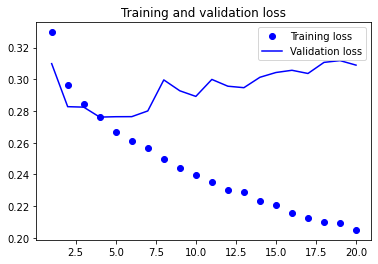

In [106]:
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()